# Proveedores de datos de mercado

1. [Financial modelling Prep](https://site.financialmodelingprep.com/)
2. Alpha Vantage (datos historicos de minuto, pero calls diarias limitadas, datos fuera de horario de mercado)
3. Quandl
4. Tiingo (los datos de minuto no estan ajustados a splits)
5. Yahoo finance
6. EOD Historical Data API
7. OpenFin API
8. Marketstack
9. FinnHub (tick data de pago)
10. [Polygon.io](https://polygon.io/pricing) (tick data de pago)

# Financial Modelling Prep

Para los datos de minuto tenemos que buscar `Stock Historical Price` en la documentación. El endpoint es el siguiente:

Endpoint:
```
"https://financialmodelingprep.com/api/v3/historical-chart/5min/AAPL?from=2023-08-10&to=2023-09-10&apikey=YOUR_API_KEY"
```

In [1]:
from urllib.request import urlopen
import certifi
import json
import ssl
import pandas as pd

In [2]:
# Create a secure SSL context
ssl_context = ssl.create_default_context(cafile=certifi.where())

In [3]:
def get_jsonparsed_data(url):
  response = urlopen(url, context=ssl_context)
  data = response.read().decode("utf-8")
  return json.loads(data)

In [4]:
import pandas as pd
import requests
from datetime import datetime, timedelta
def get_intraday_data(symbol: str, interval: str = '1min', start_date: str = None, end_date: str = None) -> pd.DataFrame:
    """
    Retrieves intraday stock data for a given symbol from Financial Modelling Prep API within a specified date range.
    
    Args:
    - api_key (str): Your API key for Financial Modelling Prep.
    - symbol (str): The stock symbol to retrieve intraday data for.
    - interval (str): The interval for the data (1min, 5min, 15min, 30min, 1hour).
    - start_date (str): The start date for the data in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the data in 'YYYY-MM-DD' format.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the intraday stock data.
    """
    FMP_API = "5XECrkjuQiIHlz4qd4KTd0PnAEVJZs9j"
    # Create a secure SSL context
    ssl_context = ssl.create_default_context(cafile=certifi.where())

    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    print(f"Fetching data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

    all_data = []
    try:
        # Iterate over the date range in increments of two days
        current_start_date = start_date
        while current_start_date < end_date:
            current_end_date = min(current_start_date + timedelta(days=1), end_date)

            # Format dates as strings
            str_start_date = current_start_date.strftime('%Y-%m-%d')
            str_end_date = current_end_date.strftime('%Y-%m-%d')

            # # # Make API call
            url = f"https://financialmodelingprep.com/api/v3/historical-chart/{interval}/{symbol}?from={str_start_date}&to={str_end_date}&apikey={FMP_API}"
            with urlopen(url, context=ssl_context) as response:
                if response.status == 200:
                        data = json.loads(response.read().decode())
                        if data:  # Check if data is not empty
                            all_data.extend(data)
                        else:
                            print(f"No data returned for {str_start_date} to {str_end_date}")
                else:
                    print(f"Failed to fetch data for {str_start_date} to {str_end_date}: {response.status}")

            # Move the start date forward by two days
            current_start_date = current_end_date + timedelta(days=1) 
    
    except Exception as e:
        print(f"Error fetching data for {str_start_date} to {str_end_date}: {e}")
       

    finally:
        # Convert the list of data to a DataFrame
        df = pd.DataFrame(all_data)

        if not df.empty:
            # Convert 'date' column to datetime
            df['date'] = pd.to_datetime(df['date'])
            # Sort the DataFrame by 'date'
            df = df.sort_values(by='date').reset_index(drop=True)

            # Print the range of dates
            print(f"Data fetched from {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
        else:
            print("No data fetched.")
        return df


In [6]:
response_data = get_intraday_data('BTCUSD', '1min', start_date ='2024-01-01', end_date='2024-06-30')

Fetching data from 2024-01-01 to 2024-06-30
Data fetched from 2024-01-01 to 2024-06-30


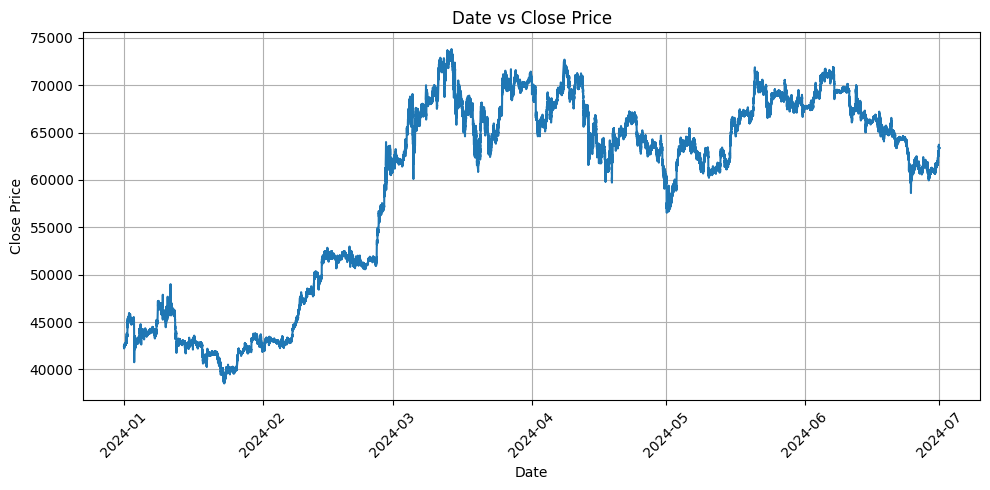

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotear date contra close
plt.figure(figsize=(10, 5))
plt.plot(response_data['date'], response_data['close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Date vs Close Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
response_data.to_parquet('BTC_1min_2024-01-01_to_2024-06-30.parquet')

In [13]:
# Unir los DataFrames
combined_df = pd.concat([loaded_df, response_data])
combined_df = combined_df.sort_values(by='date')
combined_df = combined_df.reset_index(drop=True)

combined_df.to_parquet('BTC_1min_2018-01-01_to_2023-04-08.parquet')

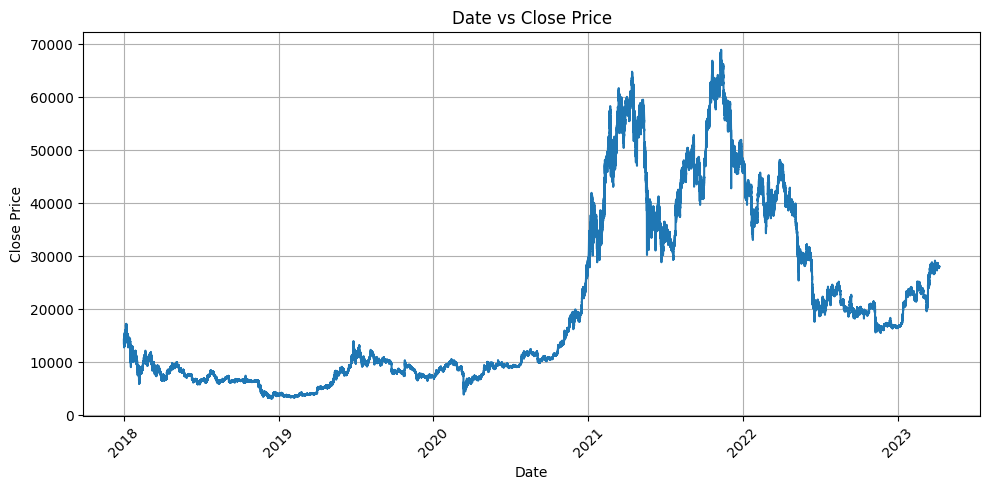

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotear date contra close
plt.figure(figsize=(10, 5))
plt.plot(combined_df['date'], combined_df['close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Date vs Close Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# con horarios de mercado, y no con dias naturales.

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import ssl
import certifi
from urllib.request import urlopen
import json
import pandas_market_calendars as mcal

def get_intraday_data(symbol: str, interval: str = '1min', start_date: str = None, end_date: str = None) -> pd.DataFrame:
    """
    Retrieves intraday stock data for a given symbol from Financial Modelling Prep API within a specified date range.
    
    Args:
    - symbol (str): The stock symbol to retrieve intraday data for.
    - interval (str): The interval for the data (1min, 5min, 15min, 30min, 1hour).
    - start_date (str): The start date for the data in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the data in 'YYYY-MM-DD' format.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the intraday stock data.
    """
    FMP_API = "5XECrkjuQiIHlz4qd4KTd0PnAEVJZs9j"
    # Create a secure SSL context
    ssl_context = ssl.create_default_context(cafile=certifi.where())

    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    print(f"Fetching data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

    all_data = []

    # Get NYSE trading days
    nyse = mcal.get_calendar('NYSE')
    trading_days = nyse.valid_days(start_date=start_date, end_date=end_date)

    try:
        # Iterate over the trading days in increments of two days
        for i in range(0, len(trading_days), 2):
            current_start_date = trading_days[i]
            current_end_date = trading_days[min(i + 1, len(trading_days) - 1)]

            # Format dates as strings
            str_start_date = current_start_date.strftime('%Y-%m-%d')
            str_end_date = current_end_date.strftime('%Y-%m-%d')

            print(f"Fetching data from {str_start_date} to {str_end_date}")

            # Make API call
            url = f"https://financialmodelingprep.com/api/v3/historical-chart/{interval}/{symbol}?from={str_start_date}&to={str_end_date}&apikey={FMP_API}"
            with urlopen(url, context=ssl_context) as response:
                if response.status == 200:
                    data = json.loads(response.read().decode())
                    if data:  # Check if data is not empty
                        all_data.extend(data)
                    else:
                        print(f"No data returned for {str_start_date} to {str_end_date}")
                else:
                    print(f"Failed to fetch data for {str_start_date} to {str_end_date}: {response.status}")

    except Exception as e:
        print(f"Error fetching data: {e}")

    finally:
        # Convert the list of data to a DataFrame
        df = pd.DataFrame(all_data)

        if not df.empty:
            # Convert 'date' column to datetime
            df['date'] = pd.to_datetime(df['date'])
            # Sort the DataFrame by 'date'
            df = df.sort_values(by='date').reset_index(drop=True)

            # Print the range of dates
            print(f"Data fetched from {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
        else:
            print("No data fetched.")

        return df

# Ejemplo de uso
start_date = "2018-01-01"
end_date = "2018-01-31"
df = get_intraday_data('BTCUSD', '1min', start_date, end_date)
print(df)
